# Clasificación de imágenes usando una red profunda

**Profesor:** Roberto Muñoz <br />
**E-mail:** <rmunoz@metricarts.com> <br />

**Profesor:** Sebastián Arpón <br />
**E-mail:** <rmunoz@metricarts.com> <br />


Usaremos el dataset de perros y gatos. El dataset completo se puede descargar desde el link https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf

tf.enable_eager_execution()

import os
import time
import glob
import requests
import zipfile

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tf.__version__

'1.11.0'

## 1. Descargamos los datos

Descargamos un dataset pequeño de perros y gatos. Lo descargamos ejecutando el siguiente código

In [4]:
data_url = "https://metriclearning.blob.core.windows.net/tensorflow/cats_and_dogs_small.zip"

# En caso de querer descargar un dataset un poco mas grande
# use este link https://metriclearning.blob.core.windows.net/tensorflow/cats_and_dogs_medium.zip

data_dir = "data"
data_file = os.path.join(data_dir, "cats_and_dogs_small.zip")

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

response = requests.get(data_url)
response_data = response.content

with open(data_file, 'wb') as f:
    f.write(response_data)

with open(data_file, 'rb') as f:
    zf = zipfile.ZipFile(f)
    zf.extractall(data_dir)

Hacemos un resize de las imágenes a 150 x 150 pixels

In [5]:
def read_dir(directory):
    cats = glob.glob(os.path.join(directory,"cats") + '/*.jpg')
    dogs = glob.glob(os.path.join(directory,"dogs") + '/*.jpg')
    m_images = cats + dogs
    
    m_labels = []
    m_labels.extend([CAT] * len(cats))
    m_labels.extend([DOG] * len(dogs))
    assert len(m_labels) == len(m_images)
    LABELS_DIMENSIONS = 2
    m_labels = tf.one_hot(m_labels, LABELS_DIMENSIONS)
    print("Encontre %d imagenes y etiquetas en %s" %(len(m_images),directory))
    return m_images, m_labels

def load_image(path_to_image, p_label):
    m_label = p_label
    m_image = tf.read_file(path_to_image)
    m_image = tf.image.decode_jpeg(m_image)
    m_image = tf.image.resize_images(m_image,(150,150))
    m_image = m_image / 255
    return m_image, m_label

In [6]:
data_dir = "data/cats_and_dogs_small"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir , "validation")

CAT = 0
DOG = 1

print("Carpeta con imagenes para el entrenamiento: ", train_dir)
print("Carpeta con imagenes para la validación: ", val_dir)
print()

train_images, train_labels = read_dir(train_dir)
val_images, val_labels = read_dir(val_dir)

Carpeta con imagenes para el entrenamiento:  data/cats_and_dogs_small/train
Carpeta con imagenes para la validación:  data/cats_and_dogs_small/validation

Encontre 320 imagenes y etiquetas en data/cats_and_dogs_small/train
Encontre 80 imagenes y etiquetas en data/cats_and_dogs_small/validation


(150, 150, 3)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


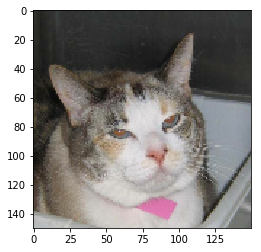

In [7]:
i=np.random.randint(len(train_images))

img, label = load_image(train_images[i], train_labels[i])

print(img.shape)
print(label)

plt.imshow(img)

## 2. Cargamos los datos en TensforFlow usando `tf.data`

In [8]:
batch_size = 64
buffer_size = 1000

train_data_set = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_data_set = train_data_set.shuffle(buffer_size).map(load_image).batch(batch_size)

val_data_set = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_data_set = val_data_set.shuffle(buffer_size).map(load_image).batch(len(val_images))

La variable train_data_set contiene las imagenes del dataset de entrenamiento ordenadas en batches. Imprimimos en pantalla el tipo de dato y recorrimos cada batch.

In [9]:
print(type(train_data_set))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [10]:
print(type(val_data_set))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [11]:
for batch_i, (batch_image, batch_label) in enumerate(train_data_set):
    print("Batch iteration: ", batch_i)
    print("Batch image type: ", type(batch_image))
    print("Batch image shape: ", batch_image.shape)
    print("Batch label type: ", type(batch_label))
    print("Batch label shape: ", batch_label.shape)
    print()

Batch iteration:  0
Batch image type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Batch image shape:  (64, 150, 150, 3)
Batch label type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Batch label shape:  (64, 2)

Batch iteration:  1
Batch image type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Batch image shape:  (64, 150, 150, 3)
Batch label type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Batch label shape:  (64, 2)

Batch iteration:  2
Batch image type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Batch image shape:  (64, 150, 150, 3)
Batch label type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Batch label shape:  (64, 2)

Batch iteration:  3
Batch image type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Batch image shape:  (64, 150, 150, 3)
Batch label type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Batch label shape:  (64, 2)

Batch iteration:  4
Batch image type:  <class 'tensorflow.python.fra

## 3. Definimos el modelo y lo entrenamos

### Definimos la arquitectura de la red

Usamos el método `AdamOptimizer` como funcion de optimización

In [12]:
tf.keras.backend.clear_session()

In [13]:
def create_model():

    model = tf.keras.Sequential()

    model.add(tf.layers.Conv2D(16, (5,5), activation=tf.nn.relu, input_shape=(150,150,3)))

    model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))

    model.add(tf.layers.Conv2D(64,(3,3),activation=tf.nn.relu))
    model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.layers.Conv2D(128,(3,3),activation=tf.nn.relu))
    model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.layers.Conv2D(128,(3,3),activation=tf.nn.relu))
    model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.layers.Flatten())
    model.add(tf.layers.Dense(512,activation=tf.nn.relu))
    model.add(tf.layers.Dense(2,activation=tf.nn.softmax))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.train.AdamOptimizer(),
                  metrics=['accuracy'])
    
    return model
    
model = create_model()    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 146, 146, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
__________

### Entrenamos el modelo usando `train_on_batch()`

In [14]:
def write_log(callback, names, logs, epoch_no):
    '''
    Auxiliary function to manually write TensorFlow log files 
    '''
    for name, value in zip(names, logs):
        summary = tf.contrib.summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, epoch_no)
        callback.writer.flush()

In [15]:
checkpoint_dir='results'

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [16]:
EPOCHS = 30

train_loss_epoch_list=[]
train_acc_epoch_list=[]

val_loss_epoch_list=[]
val_acc_epoch_list=[]

for epoch in range(EPOCHS):
    
    progbar = tf.keras.utils.Progbar(5)
    for (batch, (images, labels)) in enumerate(train_data_set):
        train_loss, train_accuracy = model.train_on_batch(images, labels)
        progbar.add(1, values=[("train loss", train_loss), ("acc", train_accuracy)])

    model.save_weights("results/model_cats_and_dogs_{:04d}.ckpt".format(epoch+1))
        
    train_loss_epoch_list.append(float(train_loss))
    train_acc_epoch_list.append(float(train_accuracy))
    print('Entrenamiento época #%d\t Loss: %.6f\t Accuracy:  %.6f\t'% (epoch+1, train_loss, train_accuracy))
    
    iterator = val_data_set.make_one_shot_iterator()
    images, labels = iterator.get_next()
    val_loss, val_accuracy = model.evaluate(images, labels)
    
    val_loss_epoch_list.append(float(val_loss))
    val_acc_epoch_list.append(float(val_accuracy))
    print('Validacion época #%d\t Loss: %.6f\t Accuracy:  %.6f\t' % (epoch+1, val_loss, val_accuracy))                  


5/5 [==============================] - 249s 50s/step - train loss: 0.8256 - acc: 0.5219
Entrenamiento época #1	 Loss: 0.707573	 Accuracy:  0.500000	
3/3 [==============================] - 21s 7s/step
Validacion época #1	 Loss: 0.695155	 Accuracy:  0.500000	
5/5 [==============================] - 247s 49s/step - train loss: 0.6974 - acc: 0.4813
Entrenamiento época #2	 Loss: 0.709285	 Accuracy:  0.421875	
3/3 [==============================] - 19s 6s/step
Validacion época #2	 Loss: 0.692274	 Accuracy:  0.500000	
5/5 [==============================] - 245s 49s/step - train loss: 0.6908 - acc: 0.5062
Entrenamiento época #3	 Loss: 0.692012	 Accuracy:  0.484375	
3/3 [==============================] - 23s 8s/step
Validacion época #3	 Loss: 0.690124	 Accuracy:  0.487500	
5/5 [==============================] - 245s 49s/step - train loss: 0.6852 - acc: 0.5531
Entrenamiento época #4	 Loss: 0.679068	 Accuracy:  0.656250	
3/3 [==============================] - 20s 7s/step
Validacion época #4	 Loss:

### Graficamos la evolución de la función de costo

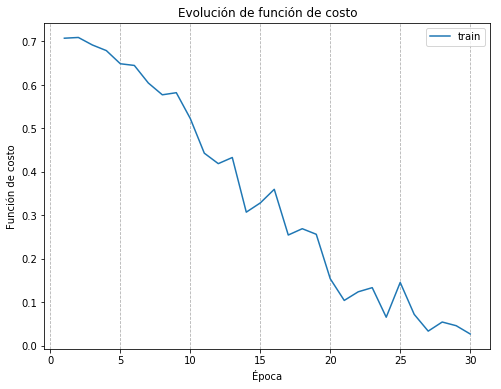

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

x=x=np.arange(EPOCHS)+1
ax.plot(x, train_loss_epoch_list, label="train")

plt.xlabel("Época")
plt.ylabel("Función de costo")
plt.legend()
ax.grid(which='major', axis='x', linestyle='--')

plt.title("Evolución de función de costo")
fig.savefig('results/loss_function_cats_and_dogs.png')

### Graficamos la evolución del accuracy

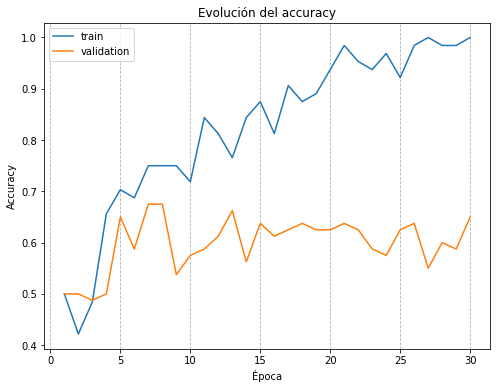

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

x=np.arange(EPOCHS)+1
ax.plot(x, train_acc_epoch_list, label="train")
ax.plot(x, val_acc_epoch_list, label="validation")

plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
ax.grid(which='major', axis='x', linestyle='--')

plt.title("Evolución del accuracy")
fig.savefig('results/accuracy_cats_and_dogs.png')

## 4. Revisamos el rendimiento del modelo en diferentes épocas

Listamos los pesos que guardamos para cada época

In [19]:
pattern = os.path.join("results/model_cats*.ckpt")
checkpoints = sorted(glob.glob(pattern))

for file in checkpoints:
    print(file)

Para validar el rendimiento del modelo usaremos el dataset de validación `val_data_set`

Recuperamos los pesos para la **época 1** y evaluamos el modelo.

In [20]:
weight_file = 'results/model_cats_and_dogs_0001.ckpt'

model = create_model()
model.load_weights(weight_file)

iterator = val_data_set.make_one_shot_iterator()
images, labels = iterator.get_next()  

loss, acc = model.evaluate(images, labels)

print("Evaluation - Model accuracy: {:.4f}".format(acc))

3/3 [==============================] - 17s 6s/step
Evaluation - Model accuracy: 0.5000


Recuperamos los pesos para la **época 30** y evaluamos el modelo.

In [21]:
weight_file = 'results/model_cats_and_dogs_0030.ckpt'

model = create_model()
model.load_weights(weight_file)

iterator = val_data_set.make_one_shot_iterator()
images, labels = iterator.get_next()  

loss, acc = model.evaluate(images, labels)

print("Evaluation - Model accuracy: {:.4f}".format(acc))

3/3 [==============================] - 17s 6s/step
Evaluation - Model accuracy: 0.6500


¿Que tál si revisamos el gráfico de evolución del accuracy y elegimos un época intermedia?

Vemos que la **época 6** tiene un accuracy más alto que el resto.

In [22]:
weight_file = 'results/model_cats_and_dogs_0006.ckpt'

model = create_model()
model.load_weights(weight_file)

iterator = val_data_set.make_one_shot_iterator()
images, labels = iterator.get_next()  

loss, acc = model.evaluate(images, labels)

print("Evaluation - Model accuracy: {:.4f}".format(acc))

3/3 [==============================] - 17s 6s/step
Evaluation - Model accuracy: 0.5875


Definitivamente los pesos obtenidos en la época 6 son los mejores que obtuvimos en este entrenamiento. Usaremos estos pesos para evaluar el rendimiento en imágenes nuevas.

## 5. Descargamos imágenes nuevas y predecimos a qué clase pertencen

In [23]:
import requests
import io
import imageio
from skimage.transform import resize

ModuleNotFoundError: No module named 'imageio'

In [ ]:
url="https://misanimales.com/wp-content/uploads/2014/12/gato-enfermo.jpg"

response = requests.get(url, stream=True)
im = imageio.imread(io.BytesIO(response.content))

plt.imshow(im)

Revisamos las dimensiones de la imagen

In [ ]:
print(type(im))
print(im.shape)
print(np.min(im))
print(np.max(im))

Para usar el método predict() de TensorFlow primero debemos cambiar el tamaño de la imagen a 150x150 pixels, luego transformar la imagen en un Tensor y finalmente agregar una dimensión extra al comienzo

In [ ]:
im_np = np.array(im)
im_np = resize(im_np, (150,150))
im_np = im_np.astype('float32')

im_tf = tf.convert_to_tensor(im_np)
im_tf = tf.expand_dims(im_tf, 0)

In [ ]:
np.max(im_np)

In [ ]:
model.predict(im_tf)

In [ ]:
model.predict_classes(im_tf)

In [ ]:
def predict_url(url):
    response = requests.get(url, stream=True)
    im = imageio.imread(io.BytesIO(response.content))
    
    plt.imshow(im)
    plt.show()
    
    im_np = np.array(im)
    im_np = resize(im_np, (150,150))
    im_np = im_np.astype('float32')

    im_tf = tf.convert_to_tensor(im_np)
    im_tf = tf.expand_dims(im_tf, 0)
    
    predict_class = model.predict_classes(im_tf)
    
    if predict_class == 0:
        print("Predicción del modelo: Gato")
    elif predict_class == 1:
        print("Predicción del modelo: Perro")

In [ ]:
url="https://misanimales.com/wp-content/uploads/2014/12/gato-enfermo.jpg"
predict_url(url)

In [ ]:
url="https://s3-eu-west-1.amazonaws.com/barkibu-blog/blog+images/mi-perro-tiene-hipo-muy-seguido-que-le-pasa/perro-hipo-1.jpg"
predict_url(url)